# **Task 1 | Mask Recognition: Classify people wearing masks**

___
___

## **1. INITIALIZATION**

### *1.1 IMPORTS*

In [1]:
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from xml.dom import minidom

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rd
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import torch
import torch.nn as nn

In [2]:
# To fill the `requirement.txt` file we use the following line of code:
import session_info
session_info.show()

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [4]:
root_dir = "data/FaceMaskDetection/"
anno_dir = root_dir + "annotations/"
imgs_dir = root_dir + "images/"

In [5]:
def get_annotations(anno_dir):

    """

    arg:
    - anno_dir (str):   the directory with the .xml annotations files
    
    out:
    - df (dataframe):   a dataframe matching an image id and a bounding box id to the size of
                        the image, the position of the bounding box and its annotation:
                        "without mask" or "mask_weared_incorrect" => 0 | "with mask" => 1  
    
    """

    files = os.listdir(anno_dir)
    files.sort()
    
    # if the dataframe doesn't exist been created yet
    if "annotations.csv" not in files:

        data = []
        mask_label = {"without_mask": 0, "mask_weared_incorrect": 1, "with_mask": 1}

        for file in files:
        
            ann = minidom.parse(anno_dir+file)
            img_id = int(ann.getElementsByTagName("filename")[0].firstChild.data[12:-4])
            img_height = int(ann.getElementsByTagName("height")[0].firstChild.data)
            img_width = int(ann.getElementsByTagName("width")[0].firstChild.data)
        
            for i,object in enumerate(ann.getElementsByTagName("object")):

                box_id = i
                label = mask_label[object.getElementsByTagName("name")[0].firstChild.data]
                xmin = object.getElementsByTagName("xmin")[0].firstChild.data
                xmax = object.getElementsByTagName("xmax")[0].firstChild.data
                ymin = object.getElementsByTagName("ymin")[0].firstChild.data
                ymax = object.getElementsByTagName("ymax")[0].firstChild.data

                data.append((img_id, img_height, img_width, box_id, label, xmin, xmax, ymin, ymax))
        
        columns = ["img_id", "img_height", "img_width", "box_id", "label", "xmin", "xmax", "ymin", "ymax"]
        pd.DataFrame(data=data, columns=columns, index=None).to_csv(anno_dir+"annotations.csv", index=None)
        
    return pd.read_csv(anno_dir+"/annotations.csv", index_col=False)

In [6]:
annotations = get_annotations(anno_dir)
display(annotations)

,img_id,img_height,img_width,box_id,label,xmin,xmax,ymin,ymax,train
0,0,366,512,0,0,79,109,105,142,True
1,0,366,512,1,1,185,226,100,144,True
2,0,366,512,2,0,325,360,90,141,True
3,1,156,400,0,1,321,354,34,69,True
4,1,156,400,1,1,224,261,38,73,False
...,...,...,...,...,...,...,...,...,...,...
4067,98,267,400,2,1,263,287,62,85,True
4068,98,267,400,3,1,344,377,80,106,True
4069,99,267,400,0,1,181,273,54,162,True
4070,99,267,400,1,1,99,176,87,165,True


In [7]:
class FaceMaskDataset(Dataset):

    def __init__(self, annotations, imgs_dir):
        self.annotations = annotations
        self.img_dir = imgs_dir
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img = plt.imread(self.img_dir+"maksssksksss{}.png".format(int(self.annotations.iloc[idx]["img_id"])))[:,:,:3]
        xmin = self.annotations.iloc[idx]["xmin"]
        xmax = self.annotations.iloc[idx]["xmax"]
        ymin = self.annotations.iloc[idx]["ymin"]
        ymax = self.annotations.iloc[idx]["ymax"]
        img = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
        label = torch.Tensor([int(self.annotations.iloc[idx]["label"])])
        return img, label

80% of the whole dataset is dedicated to training and the 20% left is used as a test dataset.

To ensure that we keep the same elements within the two datasets, even after restarting the notebook, we add add a train column to the annotation_dataframe.

In [8]:
if "train" not in annotations:

    train_size = int(0.80*len(annotations))
    train_ids = rd.sample(range(len(annotations)), train_size)
    annotations["train"] = [i in train_ids for i in range(len(annotations))]
    annotations.to_csv(anno_dir+"annotations.csv", index=None)

train_dataset = FaceMaskDataset(annotations[annotations["train"]], imgs_dir)
test_dataset = FaceMaskDataset(annotations[annotations["train"] == False], imgs_dir)

batch_size = 128

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

___

## **2. THE MODELS**

### *2.1. DEFINING THE MODELS*

In [9]:
def ResNet18(device=device):

    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.Sigmoid())
    model.to(device)
    return model

In [10]:
def ResNet50(device=device):

    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(2048,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.Sigmoid())
    model.to(device)
    return model

In [11]:
def VGG19(device=device):
    
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.Sigmoid())
    model.to(device)
    return model

### *2.2. TRAINING*

We train each of the model 5 times over 50 epochs. We then observe the evolution of their losses and accuracies, and select the best model accordingly.

In [12]:
nb_iterations = 5
nb_epochs = 50
epoch_print_frequence = 10

In [13]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence):

    s = time.time()

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(nb_epochs):

        running_loss_train, running_loss_test, running_acc_train, running_acc_test = 0,0,0,0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = test_dataloader
                model.eval()

            for inputs,labels in dataloader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 
                    
                else:
                    running_loss_test += loss.item()
                    running_acc_test += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 

        running_loss_train /= len(train_dataloader)
        running_loss_test /= len(test_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_test /= len(test_dataset)

        train_losses.append(running_loss_train)
        test_losses.append(running_loss_test)
        train_accuracies.append(running_acc_train)
        test_accuracies.append(running_acc_test)

        if (epoch+1) % epoch_print_frequence == 0:
            print("- epochs {}/{} ({} s) | train loss : {} | test loss : {} | train acc : {} | test acc : {}".format(
                epoch+1,
                nb_epochs,
                int(time.time()-s),
                int(1000000*running_loss_train)/1000000,
                int(1000000*running_loss_test)/1000000,
                int(1000000*running_acc_train)/1000000,
                int(1000000*running_acc_test)/1000000)
            )
    
    return np.array(train_losses), np.array(test_losses), np.array(train_accuracies), np.array(test_accuracies)

In [14]:
resultsRSN18 = []

for i in range(nb_iterations):

    modelRSN18 = ResNet18()
    optimizerRSN18 = torch.optim.Adam(modelRSN18.parameters(), lr=1e-3)
    criterionRSN18 = nn.BCELoss().cuda()
    print("train loop {}".format(i+1))
    resultsRSN18.append(train_model(modelRSN18, criterionRSN18, optimizerRSN18, nb_epochs, epoch_print_frequence))

train loop 1


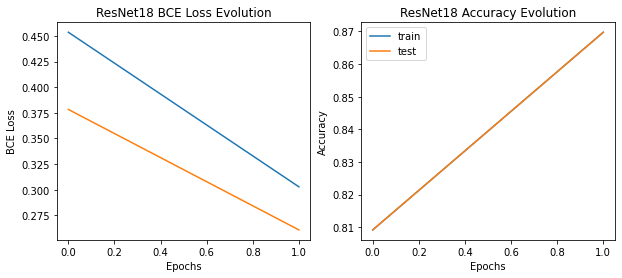

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

train_losses_RSN18 = resultsRSN18[0][0]
test_losses_RSN18 = resultsRSN18[0][1]
train_acc_RSN18 = resultsRSN18[0][2]
test_acc_RSN18 = resultsRSN18[0][3]

for i in range(1,nb_iterations):
    train_losses_RSN18 += resultsRSN18[i][0]
    test_losses_RSN18 += resultsRSN18[i][1]
    train_acc_RSN18 += resultsRSN18[i][2]
    test_acc_RSN18 += resultsRSN18[i][3]

train_losses_RSN18 /= nb_iterations
test_losses_RSN18 /= nb_iterations
train_acc_RSN18 /= nb_iterations
test_acc_RSN18 /= nb_iterations

ax[0].set(title="ResNet18 BCE Loss Evolution")
ax[0].plot(train_losses_RSN18, label="train")
ax[0].plot(test_losses_RSN18, label="test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("BCE Loss")

ax[1].set(title="ResNet18 Accuracy Evolution")
ax[1].plot(train_acc_RSN18, label="train")
ax[1].plot(train_acc_RSN18, label="test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
resultsRSN50 = []

for i in range(nb_iterations):

    modelRSN50 = ResNet50()
    optimizerRSN50 = torch.optim.Adam(modelRSN50.parameters(), lr=1e-3)
    criterionRSN50 = nn.BCELoss().cuda()
    print("train loop {}".format(i+1))
    resultsRSN50.append(train_model(modelRSN50, criterionRSN50, optimizerRSN50, nb_epochs, epoch_print_frequence))

train loop 1
epochs 1/2 (55 s) | train loss : 0.420411 | test loss : 0.375662 | train acc : 0.809026 | test acc : 0.856441
epochs 2/2 (113 s) | train loss : 0.293344 | test loss : 0.260158 | train acc : 0.857844 | test acc : 0.898159


train loop 2
epochs 1/2 (55 s) | train loss : 0.415271 | test loss : 0.355475 | train acc : 0.804114 | test acc : 0.851533
epochs 2/2 (111 s) | train loss : 0.294636 | test loss : 0.271905 | train acc : 0.842186 | test acc : 0.888343


train loop 3
epochs 1/2 (55 s) | train loss : 0.418267 | test loss : 0.356824 | train acc : 0.821 | test acc : 0.862576
epochs 2/2 (110 s) | train loss : 0.2651 | test loss : 0.264979 | train acc : 0.889775 | test acc : 0.895705


train loop 4
epochs 1/2 (59 s) | train loss : 0.42277 | test loss : 0.399273 | train acc : 0.797666 | test acc : 0.851533
epochs 2/2 (115 s) | train loss : 0.299774 | test loss : 0.280517 | train acc : 0.817009 | test acc : 0.851533


train loop 5
epochs 1/2 (57 s) | train loss : 0.400205 | test 

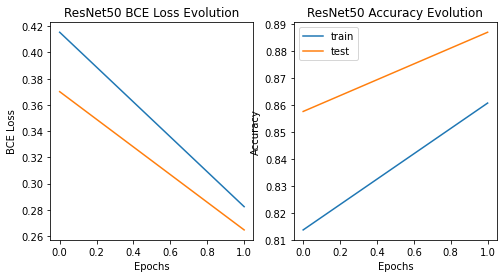

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

train_losses_RSN50 = resultsRSN50[0][0]
test_losses_RSN50 = resultsRSN50[0][1]
train_acc_RSN50 = resultsRSN50[0][2]
test_acc_RSN50 = resultsRSN50[0][3]

for i in range(1,nb_iterations):
    train_losses_RSN50 += resultsRSN50[i][0]
    test_losses_RSN50 += resultsRSN50[i][1]
    train_acc_RSN50 += resultsRSN50[i][2]
    test_acc_RSN50 += resultsRSN50[i][3]

train_losses_RSN50 /= nb_iterations
test_losses_RSN50 /= nb_iterations
train_acc_RSN50 /= nb_iterations
test_acc_RSN50 /= nb_iterations

ax[0].set(title="ResNet50 BCE Loss Evolution")
ax[0].plot(train_losses_RSN50, label="train")
ax[0].plot(test_losses_RSN50, label="test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("BCE Loss")

ax[1].set(title="ResNet50 Accuracy Evolution")
ax[1].plot(train_acc_RSN50, label="train")
ax[1].plot(test_acc_RSN50, label="test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
resultsVGG19 = []

for i in range(nb_iterations):

    modelVGG19 = VGG19()
    optimizerVGG19 = torch.optim.Adam(modelVGG19.parameters(), lr=1e-3)
    criterionVGG19 = nn.BCELoss().cuda()
    print("train loop {}".format(i+1))
    resultsVGG19.append(train_model(modelVGG19, criterionVGG19, optimizerVGG19, nb_epochs, epoch_print_frequence))
    print("\n")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

train_losses_VGG19 = resultsVGG19[0][0]
test_losses_VGG19 = resultsVGG19[0][1]
train_acc_VGG19 = resultsVGG19[0][2]
test_acc_VGG19 = resultsVGG19[0][3]

for i in range(1,nb_iterations):
    train_losses_VGG19 += resultsVGG19[i][0]
    test_losses_VGG19 += resultsVGG19[i][1]
    train_acc_VGG19 += resultsVGG19[i][2]
    test_acc_VGG19 += resultsVGG19[i][3]

train_losses_VGG19 /= nb_iterations
test_losses_VGG19 /= nb_iterations
train_acc_VGG19 /= nb_iterations
test_acc_VGG19 /= nb_iterations

ax[0].set(title="VGG19 BCE Loss Evolution")
ax[0].plot(train_losses_VGG19, label="train")
ax[0].plot(test_losses_VGG19, label="test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("BCE Loss")

ax[1].set(title="VGG19 Accuracy Evolution")
ax[1].plot(train_acc_VGG19, label="train")
ax[1].plot(test_acc_VGG19, label="test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.legend()
plt.show()

### *2.3. SAVING THE MODEL*

Given the losses and accuracies evolution we decided to use the ResNet50 in the following tasks.

In [ ]:
torch.save(modelRSN50.state_dict(), "./models/MaskRecognitionRSN50.pt")

___

## **3. TESTING THE MODELS**

### *3.1. CONFUSION MATRIX*

In [ ]:
train_labels = np.array(annotations[annotations["train"]]["label"])
test_labels = np.array(annotations[annotations["train"] == False]["label"])

In [ ]:
train_predicted_labels = []
test_predicted_labels = []

for i in tqdm(range(len(annotations))):

    xmin = annotations.iloc[i]["xmin"]
    xmax = annotations.iloc[i]["xmax"]
    ymin = annotations.iloc[i]["ymin"]
    ymax = annotations.iloc[i]["ymax"]

    label = annotations.iloc[i]["label"]

    img = plt.imread(imgs_dir+"/maksssksksss{}.png".format(annotations.iloc[i]["img_id"]))[:,:,:3]
    img_tensor = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
    img_tensor = img_tensor.reshape((1,3,64,64)).to(device)

    predRSN50 = torch.round(modelRSN50(img_tensor)).item()

    if annotations.iloc[i]["train"]:
        train_predicted_labels.append(predRSN50)
    else:
        test_predicted_labels.append(predRSN50)

train_labelsRSN50 = np.array(train_predicted_labels)
test_labelsRSN50 = np.array(test_predicted_labels)

100%|██████████| 4072/4072 [01:33<00:00, 43.58it/s]


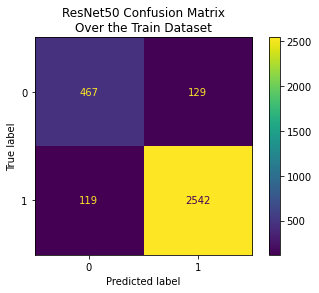

In [ ]:
train_cmRSN50 = confusion_matrix(train_labels, train_predicted_labels)
train_dispRSN50 = ConfusionMatrixDisplay(confusion_matrix=train_cmRSN50)
train_dispRSN50.plot()
plt.title("ResNet50 Confusion Matrix\nOver the Train Dataset")
plt.show()

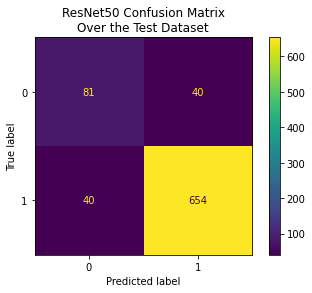

In [ ]:
test_cmRSN50 = confusion_matrix(test_labels, test_predicted_labels)
test_dispRSN50 = ConfusionMatrixDisplay(confusion_matrix=test_cmRSN50)
test_dispRSN50.plot()
plt.title("ResNet50 Confusion Matrix\nOver the Test Dataset")
plt.show()

### *3.3. VISUALIZING PREDICTION*

In [ ]:
def show_random_results(model, nb_images):

    img_ids = rd.sample(list(annotations["img_id"]), nb_images)

    for img_id in img_ids:

        a = annotations[annotations["img_id"] == img_id]
        img = plt.imread(imgs_dir+"/maksssksksss{}.png".format(img_id))[:,:,:3]
        overlay = img.copy()
        output = img.copy()

        for i in range(len(a)):
            
            xmin = a.iloc[i]["xmin"]
            xmax = a.iloc[i]["xmax"]
            ymin = a.iloc[i]["ymin"]
            ymax = a.iloc[i]["ymax"]
            
            img_tensor = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
            img_tensor = img_tensor.reshape((1,3,64,64)).to(device)
            pred = torch.round(model(img_tensor)).item()

            if pred == 0:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (2,0,0), 1)
            
            else:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (0,1,0), 1)
            
            output = cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)
            
        plt.figure(figsize=(15,9))
        plt.imshow(output)
        plt.show()

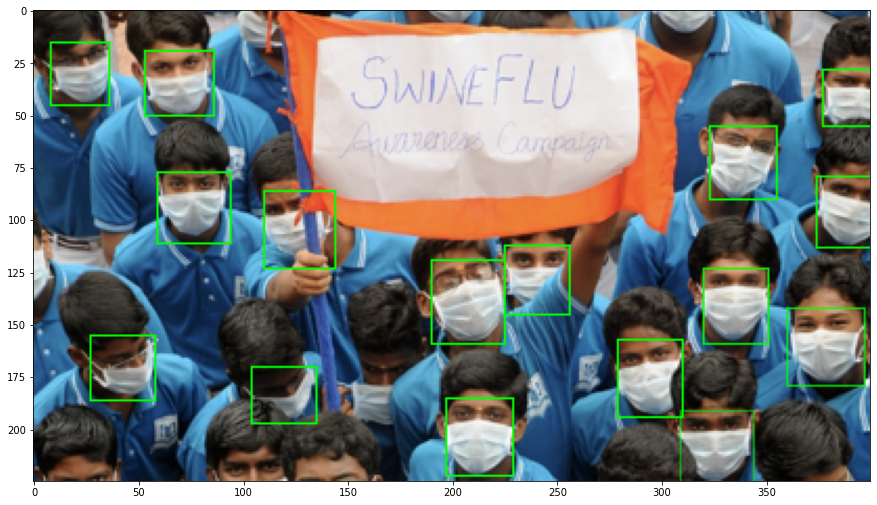

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


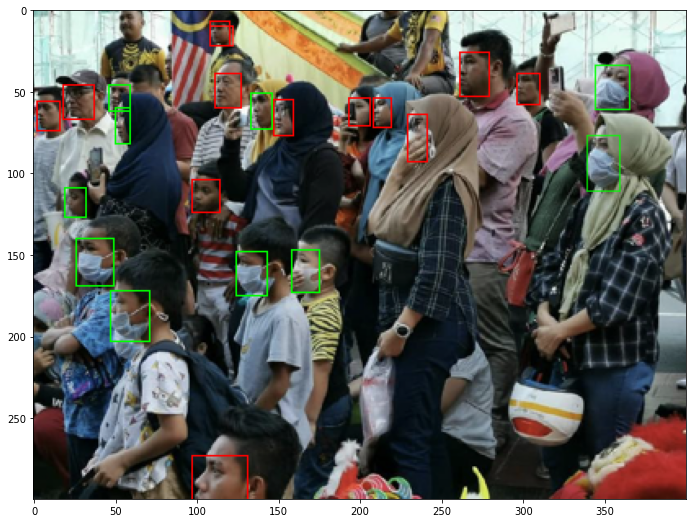

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


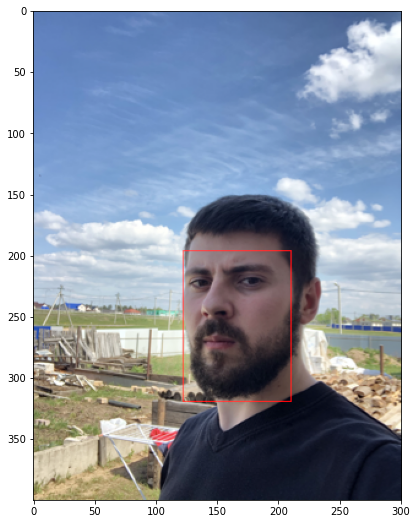

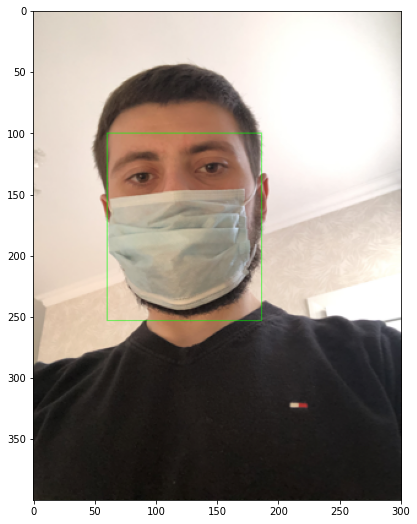

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


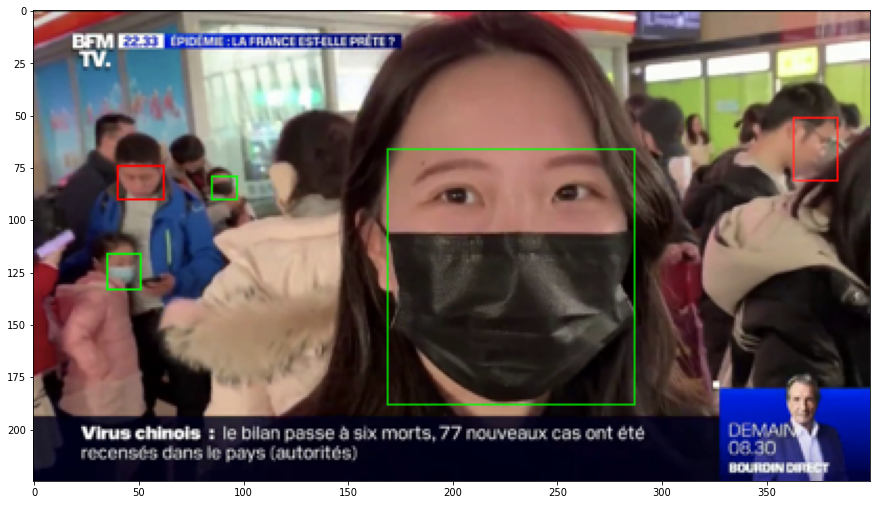

In [ ]:
show_random_results(modelRSN50, 5)